## Summary 

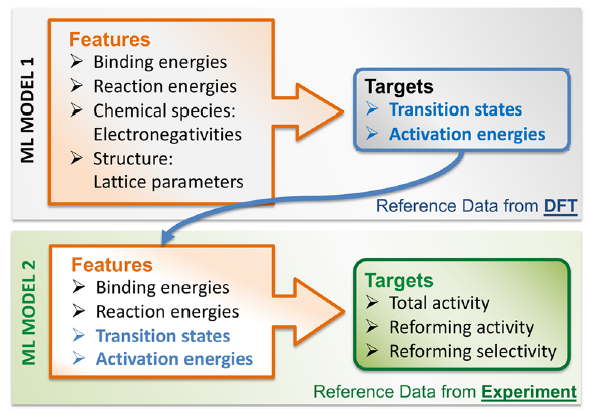

In [6]:
#!/usr/bin/env python
"""
Construct ML Model 1 for predicting transition-state energies from thermochemical DFT data and chemical information.
The model uses a combination of Random Forest Regression and Gaussian Process Regression.
"""
import argparse
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

__author__ = "Nongnuch Artrith"
__email__ = "nartrith@atomistic.net"
__date__ = "2019-11-10"
__version__ = "0.1"

In [7]:
def plot_predictions(predictions, data):
    font = FontProperties()
    font.set_size(24)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.tick_params(labelsize=24)
    surfaces = set(data['Surface'])
    for s in surfaces:
        idx = (data['Surface'] == s)
        ax.scatter(predictions[idx], data[idx]['E_TS'], label=s, s=120)
    ideal = np.linspace(0, np.max(data['E_TS']), 10)
    ax.plot(ideal, ideal, color='black')
    ax.set_xlabel('Predicted Transition State (eV)', fontproperties=font)
    ax.set_ylabel('Reference Transition State (eV)', fontproperties=font)
    font.set_size(16)
    ax.legend(loc='lower right', prop=font)
    plt.savefig('validation-TS-model-RFR+GPR.png', bbox_inches='tight')
    plt.savefig('validation-TS-model-RFR+GPR.pdf', bbox_inches='tight')

## ML Model 1

Defining Random Forest Regression and Gaussian Process Regressor 

In [8]:
def RFR(features, targets):
    model = RandomForestRegressor(
        max_depth=9, n_estimators=15, random_state=False, verbose=False)
    N = len(features)
    F = features
    T = targets.values
    predictions = []
    errors = []
    for i in range(N):
        idx = np.ones(N, dtype=bool)
        idx[i] = False
        model.fit(F[idx], T[idx])
        prediction_i = model.predict([F[i]])
        predictions.append(prediction_i)
        errors.append(prediction_i - T[i])
    predictions = np.array(predictions)
    rmse = np.std(errors)
    mae = np.mean(np.abs(errors))
    model.fit(F, T)
    return model, predictions, rmse, mae


def GPR(features, targets):
    kernel = RBF(length_scale=2.0, length_scale_bounds=(1e-05, 100000.0))
    model = GaussianProcessRegressor(
        kernel=kernel, alpha=0.05, random_state=False)
    N = len(features)
    F = features
    T = targets.values
    predictions = []
    errors = []
    for i in range(N):
        idx = np.ones(N, dtype=bool)
        idx[i] = False
        model.fit(F[idx], T[idx])
        prediction_i = model.predict([F[i]])
        predictions.append(prediction_i)
        errors.append(prediction_i - T[i])
    predictions = np.array(predictions)
    rmse = np.std(errors)
    mae = np.mean(np.abs(errors))
    model.fit(F, T)
    return model, predictions, rmse, mae

Defining the complex ML Model using RFR and GPR

In [9]:
def model(dft_data):
    data = dft_data
    features_all = data[['d_NN(top)', 'd_NN(2nd)', 'EN(top)', 'EN(2nd)',
                         'Facet', 'Eads(CH3CH2OH)', 'N_H', 'Initial', 'Final']]
    targets_all = data['E_TS']
    feature_scaler = StandardScaler().fit(
        np.array(features_all.values, dtype=np.float64))
    features_all = feature_scaler.transform(
        np.array(features_all.values, dtype=np.float64))
    select = (data['Facet'] == 1) & (data['has_TS'] == 1)
    features = features_all[select]
    targets = targets_all[select]

    # fit models and plot predictions
    model_rfr, predictions_rfr, rmse_rfr, mae_rfr = RFR(features, targets)
    model_gpr, predictions_gpr, rmse_gpr, mae_gpr = GPR(features, targets)
    predictions_mean = (predictions_rfr + predictions_gpr)/2.0
    plot_predictions(predictions_mean, data[select])

    # print out uncertainty estimate
    rmse = np.std(predictions_mean[:, 0] - targets.values)
    mae = np.std(np.abs(predictions_mean[:, 0] - targets.values))
    print("CV RMSE (RFR+GPR) = {}".format(rmse))
    print("CV MAE  (RFR+GPR) = {}".format(mae))

    # use model to predict unknown transition-state energies
    sel_predict = (data['Facet'] == 1) & (data['has_TS'] == 0)
    TS_predict_rfr = model_rfr.predict(features_all[sel_predict])
    TS_predict_gpr = model_gpr.predict(features_all[sel_predict])
    TS_predict = (TS_predict_rfr + TS_predict_gpr)/2
    data2 = data.copy()
    data2.loc[sel_predict, 'E_TS'] = TS_predict
    data2[sel_predict].to_csv('predicted-TS-RF+GPR.csv', index=False)

CV RMSE (RFR+GPR) = 0.31355735359273884
CV MAE  (RFR+GPR) = 0.19694531925449452


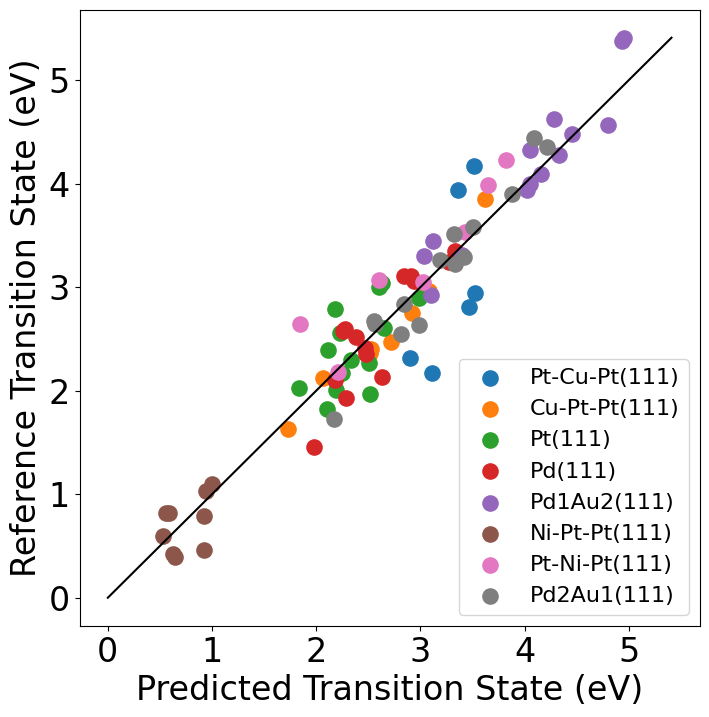

In [10]:
dft_data = pd.read_csv('E:\AdInstiActivities\SURP_CL01\ethanol-reforming-codes\database-dft.csv')
model(dft_data)

## ML Model 2

Constructing ML Model 2 for predicting catalytic activities and
selectivities.

The models are based on linear regression.

In [11]:
#!/usr/bin/env python
import argparse
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

__author__ = "Nongnuch Artrith"
__email__ = "nartrith@atomistic.net"
__date__ = "2019-11-10"
__version__ = "0.1"


warnings.filterwarnings('ignore')

In [12]:
def plot_predictions(xval, yval, fname, xlabel="x", ylabel="y",
                     axis_range=None):
    font = FontProperties()
    font.set_size(24)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.tick_params(labelsize=24)
    ax.scatter(xval, yval, s=120)
    coeff = np.polyfit(xval, yval, 1)
    line = np.poly1d(coeff)
    ax.plot(xval, line(xval), '-')
    if axis_range is not None:
        range_min = min(np.min(xval), np.min(yval), axis_range[0])
        range_max = max(np.max(xval), np.max(yval), axis_range[1])
    else:
        range_min = min(np.min(xval), np.min(yval))
        range_max = max(np.max(xval), np.max(yval))
    ax.plot(np.linspace(range_min, range_max, 10),
            np.linspace(range_min, range_max, 10), '-')
    ax.set_xlabel("{}".format(xlabel), fontproperties=font)
    ax.set_ylabel("{}".format(ylabel), fontproperties=font)
    plt.savefig('{}.png'.format(fname), bbox_inches='tight')
    plt.savefig('{}.pdf'.format(fname), bbox_inches='tight')

In [13]:
def combine_comp_expt(comp_data, expt_data, use_expt=True, surfaces=None):
    TS = {'Surface': [], 'TS_CC_1': [], 'TS_CC_2': [], 'TS_CC_3': [],
          'TS_CC_4': [], 'TS_CC_5': [], 'TS_CC_6': [], 'TS_CC_7': [],
          'TS_CO_8': [], 'TS_CO_9': [], 'TS_CO_11': [], 'TS_CO_12': [],
          'TS_CO_14': [], 'ER_CC_1': [], 'ER_CC_2': [], 'ER_CC_3': [],
          'ER_CC_4': [], 'ER_CC_5': [], 'ER_CC_6': [], 'ER_CC_7': [],
          'ER_CO_8': [], 'ER_CO_9': [], 'ER_CO_11': [], 'ER_CO_12': [],
          'ER_CO_14': []}
    if use_expt:
        if surfaces is None:
            surfaces = set(expt_data['Surface']) & set(comp_data['Surface'])
        TS.update({'Total Activity': [], 'Reforming Activity': [],
                   'Reforming': [], 'Decomposition': [], 'CH4': []})
    elif surfaces is None:
        surfaces = set(comp_data['Surface']) - set(expt_data['Surface'])
    for s in surfaces:
        TS['Surface'].append(s)
        idx = (comp_data['Surface'] == s) & (comp_data['CO_or_CC'] == 1)
        TS['TS_CC_1'].append(
            float(comp_data[idx & (comp_data['ID'] == 1)]['E_TS']))
        TS['TS_CC_2'].append(
            float(comp_data[idx & (comp_data['ID'] == 2)]['E_TS']))
        TS['TS_CC_3'].append(
            float(comp_data[idx & (comp_data['ID'] == 3)]['E_TS']))
        TS['TS_CC_4'].append(
            float(comp_data[idx & (comp_data['ID'] == 4)]['E_TS']))
        TS['TS_CC_5'].append(
            float(comp_data[idx & (comp_data['ID'] == 5)]['E_TS']))
        TS['TS_CC_6'].append(
            float(comp_data[idx & (comp_data['ID'] == 6)]['E_TS']))
        TS['TS_CC_7'].append(
            float(comp_data[idx & (comp_data['ID'] == 7)]['E_TS']))
        TS['ER_CC_1'].append(
            float(comp_data[idx & (comp_data['ID'] == 1)]['Er']))
        TS['ER_CC_2'].append(
            float(comp_data[idx & (comp_data['ID'] == 2)]['Er']))
        TS['ER_CC_3'].append(
            float(comp_data[idx & (comp_data['ID'] == 3)]['Er']))
        TS['ER_CC_4'].append(
            float(comp_data[idx & (comp_data['ID'] == 4)]['Er']))
        TS['ER_CC_5'].append(
            float(comp_data[idx & (comp_data['ID'] == 5)]['Er']))
        TS['ER_CC_6'].append(
            float(comp_data[idx & (comp_data['ID'] == 6)]['Er']))
        TS['ER_CC_7'].append(
            float(comp_data[idx & (comp_data['ID'] == 7)]['Er']))
        idx = (comp_data['Surface'] == s) & (comp_data['CO_or_CC'] == 2)
        TS['TS_CO_8'].append(
            float(comp_data[idx & (comp_data['ID'] == 8)]['E_TS']))
        TS['TS_CO_9'].append(
            float(comp_data[idx & (comp_data['ID'] == 9)]['E_TS']))
        TS['TS_CO_11'].append(
            float(comp_data[idx & (comp_data['ID'] == 11)]['E_TS']))
        TS['TS_CO_12'].append(
            float(comp_data[idx & (comp_data['ID'] == 12)]['E_TS']))
        TS['TS_CO_14'].append(
            float(comp_data[idx & (comp_data['ID'] == 14)]['E_TS']))
        TS['ER_CO_8'].append(
            float(comp_data[idx & (comp_data['ID'] == 8)]['Er']))
        TS['ER_CO_9'].append(
            float(comp_data[idx & (comp_data['ID'] == 9)]['Er']))
        TS['ER_CO_11'].append(
            float(comp_data[idx & (comp_data['ID'] == 11)]['Er']))
        TS['ER_CO_12'].append(
            float(comp_data[idx & (comp_data['ID'] == 12)]['Er']))
        TS['ER_CO_14'].append(
            float(comp_data[idx & (comp_data['ID'] == 14)]['Er']))
        if use_expt:
            idx = (expt_data['Surface'] == s)
            TS['Total Activity'].append(
                float(expt_data[idx]['Total Activity']))
            TS['Reforming Activity'].append(
                float(expt_data[idx]['Total Activity'])
                * float(expt_data[idx]['Reforming']))
            TS['Reforming'].append(float(expt_data[idx]['Reforming']))
            TS['Decomposition'].append(float(expt_data[idx]['Decomposition']))
            TS['CH4'].append(float(expt_data[idx]['CH4']))
    return pd.DataFrame(TS)

In [14]:
def linear_model(features, targets):
    model = LinearRegression()
    N = len(features)
    F = features
    T = targets
    predictions = []
    errors = []
    for i in range(N):
        idx = np.ones(N, dtype=bool)
        idx[i] = False
        model.fit(F[idx], T[idx])
        prediction_i = model.predict([F[i]])
        predictions.append(prediction_i)
        errors.append(prediction_i - T[i])
    predictions = np.array(predictions).T[0]
    rmse = np.std(errors)
    mae = np.mean(np.abs(errors))
    model.fit(F, T)
    return model, predictions, rmse, mae

In [15]:
def logit_selectivity_model(features, targets):
    def f_tgt(t):
        a = 10.0
        x = (t*0.98 + 0.01)
        return np.log(x/(1 - x))/a

    def f_prd(p):
        a = 10.0
        x = 1/(1 + np.exp(-a*p))
        return (x - 0.01)/0.98

    feature_scaler = StandardScaler().fit(np.array(features, dtype=np.float64))
    F = feature_scaler.transform(np.array(features, dtype=np.float64))
    T = f_tgt(targets)
    model, predictions, rmse, mae = linear_model(F, T)
    return model, f_prd(predictions), f_prd

In [16]:
def model(dft_data, transition_state_data, experimental_data):
    comp_data_all = dft_data
    comp_data = comp_data_all[comp_data_all['has_TS'] == 1]
    predict_data = transition_state_data
    combined_data = pd.concat([comp_data, predict_data])
    expt_data = experimental_data
    data = combine_comp_expt(combined_data, expt_data)

    # model for reforming activity 'a'
    sel_features_a = ['TS_CC_2', 'TS_CO_8', 'ER_CO_8']
    features = data[sel_features_a].values
    targets = data['Reforming Activity'].values
    model_a, predictions_a, rmse_a, mae_a = linear_model(features, targets)
    plot_predictions(targets, predictions_a,
                     "validation-reforming-activity-model",
                     xlabel="Activity from Experiment (ml)",
                     ylabel="Predicted Reforming Activity (ml)")
    print("Reforming Activity Model:")
    print("  CV RMSE = {}".format(rmse_a))
    print("  CV MAE  = {}".format(mae_a))

    # predict unknown reforming activities
    surfaces = ['Pt(111)', 'Sc-Pt-Pt(111)', 'Pt-Sc-Pt(111)',
                'Ti-Pt-Pt(111)', 'Pt-Ti-Pt(111)', 'V-Pt-Pt(111)',
                'Pt-V-Pt(111)', 'Cr-Pt-Pt(111)', 'Pt-Cr-Pt(111)',
                'Mn-Pt-Pt(111)', 'Pt-Mn-Pt(111)', 'Fe-Pt-Pt(111)',
                'Pt-Fe-Pt(111)', 'Co-Pt-Pt(111)', 'Pt-Co-Pt(111)',
                'Ni-Pt-Pt(111)', 'Pt-Ni-Pt(111)', 'Cu-Pt-Pt(111)',
                'Pt-Cu-Pt(111)', 'Zn-Pt-Pt(111)', 'Pt-Zn-Pt(111)']
    data_noexpt = combine_comp_expt(
        combined_data, expt_data, use_expt=False, surfaces=surfaces)
    features = data_noexpt[sel_features_a].values
    predictions = model_a.predict(features)
    out = pd.DataFrame({"Predicted Reforming Activity": predictions,
                        "Surface": data_noexpt['Surface']})
    out.to_csv('predicted-reforming-activity.csv', index=False)

    # model for total activity 'A'
    sel_features_A = ['TS_CC_6', 'TS_CO_8', 'ER_CC_4', 'ER_CC_5']
    features = data[sel_features_A].values
    targets = data['Total Activity'].values
    model_A, predictions_A, rmse_A, mae_A = linear_model(features, targets)

    # reforming selectivity 'S = a/A'
    reforming_activity = model_a.predict(data[sel_features_a].values)
    total_activity = model_A.predict(data[sel_features_A].values)
    selectivity = reforming_activity/total_activity
    plot_predictions(data['Reforming'], selectivity,
                     "validation-reforming-selectivity-from-total-activity",
                     xlabel="Selectivity from Experiment",
                     ylabel="Predicted Selectivity")

    # predict unknown selectivities with S model 1
    reforming_activity = model_a.predict(data_noexpt[sel_features_a].values)
    total_activity = model_A.predict(data_noexpt[sel_features_A].values)
    selectivity = reforming_activity/total_activity
    out = pd.DataFrame({"Predicted Reforming Selectivity": selectivity,
                        "Surface": data_noexpt['Surface']})
    out.to_csv('predicted-reforming-selectivity-from-total-activity.csv',
               index=False)

    # logit selectivity model
    sel_features_S = ['TS_CC_2', 'TS_CC_3', 'ER_CC_2', 'ER_CC_4']
    features = data[sel_features_S].values
    targets = data['Reforming'].values
    model_S, predictions_S, f_prd = logit_selectivity_model(features, targets)
    plot_predictions(targets, predictions_S,
                     "validation-reforming-selectivity-logit",
                     xlabel="Selectivity from Experiment",
                     ylabel="Predicted Selectivity",
                     axis_range=[0, 1])

    # predict unknown selectivities with S model 2
    features = data_noexpt[sel_features_S].values
    predictions = f_prd(model_S.predict(features))
    out = pd.DataFrame({"Predicted Reforming Selectivity": predictions,
                        "Surface": data_noexpt['Surface']})
    out.to_csv('predicted-reforming-selectivity-logit.csv', index=False)

Reforming Activity Model:
  CV RMSE = 0.003606028759644104
  CV MAE  = 0.0033449441185262256


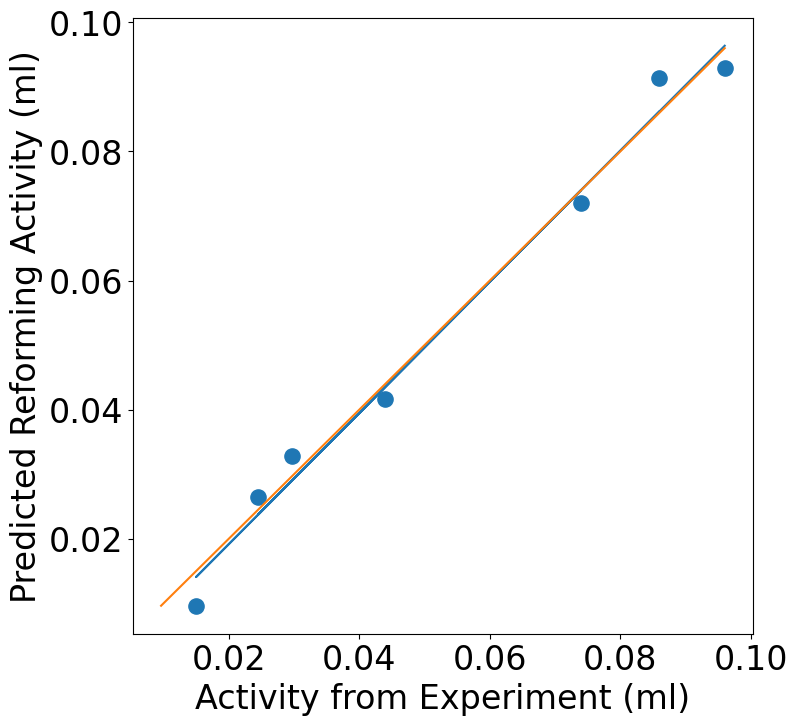

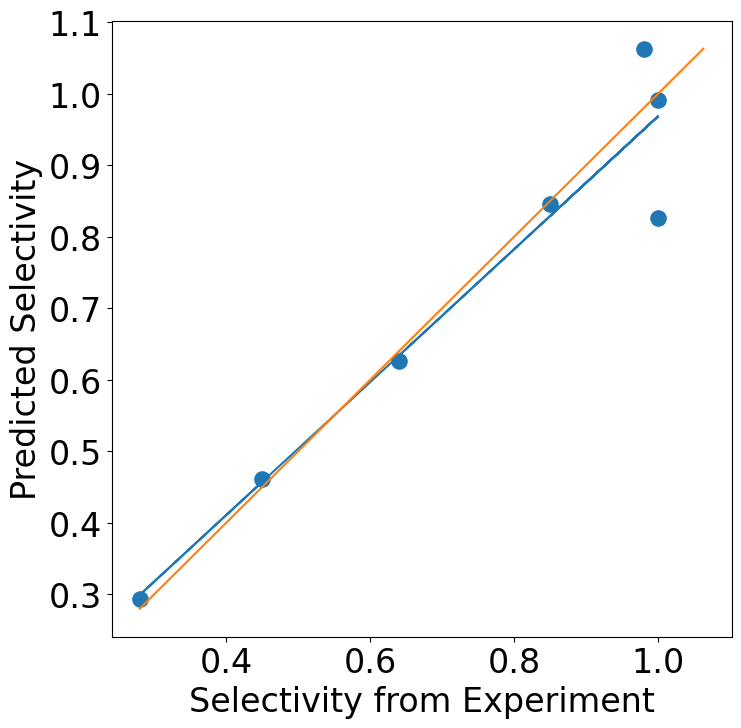

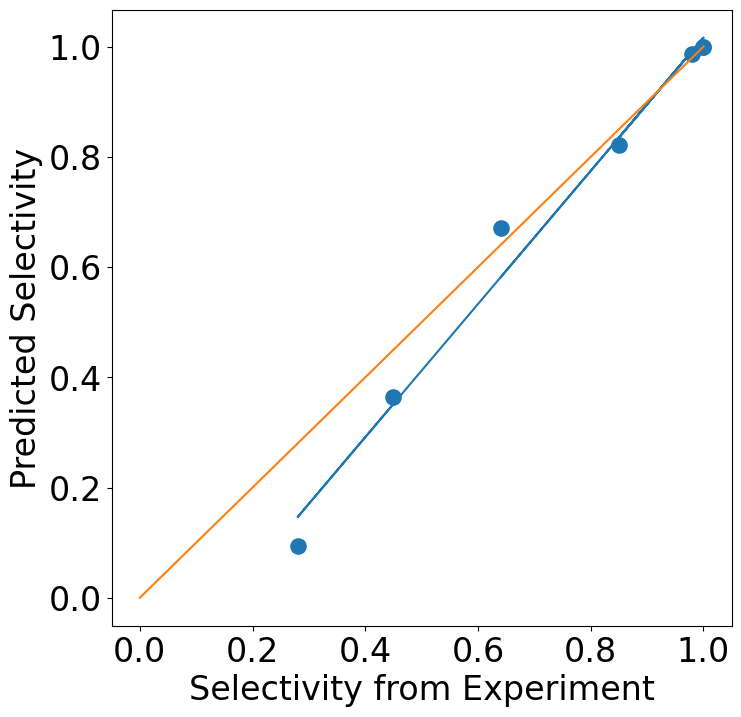

In [17]:
dft_data = pd.read_csv('E:\AdInstiActivities\SURP_CL01\ethanol-reforming-codes\database-dft.csv')
transition_state_data = pd.read_csv('E:\AdInstiActivities\SURP_CL01\ethanol-reforming-codes\predicted-TS-RF+GPR.csv')
experimental_data = pd.read_csv('E:\AdInstiActivities\SURP_CL01\ethanol-reforming-codes\database-experiment.csv')
model(dft_data, transition_state_data, experimental_data)